# L9d: Modern Hopfield Networks

___
In this lab, we'll implement a modern version of Hopfield Networks, which are a type of recurrent neural network. Hopfield Networks are used for associative memory, where the network can recall a pattern from a partial input. The modern version of Hopfield Networks uses continuous values instead of binary values, and it can store multiple patterns. 

We'll use the following paper to guide our implementation:
* [Ramsauer, H., Schafl, B., Lehner, J., Seidl, P., Widrich, M., Gruber, L., Holzleitner, M., Pavlovi'c, M., Sandve, G.K., Greiff, V., Kreil, D.P., Kopp, M., Klambauer, G., Brandstetter, J., & Hochreiter, S. (2020). Hopfield Networks is All You Need. ArXiv, abs/2008.02217.](https://arxiv.org/abs/2008.02217)

## Tasks
Before we get started, we'll do a quick review of a Hopfield Networks. Then, you'll execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!

* __Task 1: Setup, Data, Constants (5 min)__: Let's take 5 minutes to load [a Simpsons character library from Kaggle](https://www.kaggle.com/datasets/kostastokis/simpsons-faces) that our Hopfield network will memorize.
*  __Task 2: Build a Modern Network Model (5 min)__: In this task, we'll formulate a the image dataset that we give the network, and then we'll create a model of a modern Hopfield network. We'll do a quick check to make sure we are doing what we think we are doing.
* __Task 3: Retrieve a memory from the network (30 min)__: In this task, we will retrieve a memory from the modern Hopfield network starting from a random state vector $\mathbf{s}_{\circ}$. We'll corrupt an image (but cutting off some fraction of the image), and then see if the model recovers the correct memory given the corrputed starting point. 

Let's get started!
___

## Background
A modern Hopfield network addresses many of the percived limitations of the original Hopfield network. The original Hopfield network was limited to binary values, and it could only store a limited number of patterns. The modern Hopfield network uses continuous values, and it can store multiple patterns.
* For a detailed discussion of the key milestones in the development of modern Hopfield networks, check out: [Hopfield Networks is All You Need Blog, GitHub.io](https://ml-jku.github.io/hopfield-layers/)

### Algorithm
The user provides a set of memory vectors $\mathbf{X} = \left\{\mathbf{x}_{1}, \mathbf{x}_{2}, \ldots, \mathbf{x}_{m}\right\}$, where $\mathbf{x}_{i} \in \mathbb{R}^{n}$ is a memory vector of size $n$ and $m$ is the number of memory vectors. Further, the user provides an initial _partial memory_ $\mathbf{s}_{\circ} \in \mathbb{R}^{n}$, which is a vector of size $n$ that is a partial version of one of the memory vectors, and specifies the _temperature_ $\beta$ of the system.

The algorithm proceeds as follows:
1. Initialize the network with the memory vectors $\mathbf{X}$, the temperature $\beta$, set $t\gets{0}$ and set $\mathbf{s} \gets \mathbf{s}_{\circ}$.
2. Until convergence __do__:
   1. Compute the probability vector at iteration $t$ defined as $\mathbf{p}_{t} = \texttt{softmax}(\beta\cdot\mathbf{X}^{\top}\mathbf{s}_{t})$ where $\mathbf{s}_{t}$ is the state vector at iteration $t$.
   2. Compute the next state vector $\mathbf{s}_{t+1} = \mathbf{X}\cdot\mathbf{p}_{t}$ and the _next_ probability vector $\mathbf{p}_{t+1} = \texttt{softmax}(\beta\cdot\mathbf{X}^{\top}\mathbf{s}_{t+1})$.
   4. If $\mathbf{p}_{t+1}$ is _close_ to $\mathbf{p}_{t}$, then __stop__. 
   5. Otherwise, update the state $\mathbf{s}_{t} \gets\mathbf{s}_{t+1}$, the probability $\mathbf{p}_{t}\gets\mathbf{p}_{t+1}$ and the iteration counter $t \gets t+1$, and __go to__ step 2.


## Task 1: Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [1]:
include("Include.jl"); # load a bunch of libs, including the ones we need to work with images

In [2]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end]; # helper function to get the file extension

### Load the Simpsons characters data set
In this example, we'll use a Hopfield network to learn a single image pattern from [the MNIST Simpsons dataset](https://github.com/alvarobartt/simpsons-mnist). The goal is to train the network to recognize and retrieve a Simpsons character input from a noisy input.

Load a training image dataset that we'll encode into the modern Hopfield network. We'll save training data in the `training_image_dataset` variable.
* _What's in the training dataset_? The `training_image_dataset` will be of type `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` where the first element is the input data `x.` The second element is the `label,` encoded as an `OneHotVector,` where `0,....,9` corresponds to:



* _Hmmm. That's strange_. The `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` type has a couple of _weird features_. First, notice that the floating point is `Float32`, not the default `Float64`. Next, the labels are [One Hot ecoded](https://en.wikipedia.org/wiki/One-hot). Finally, the input data `x` is a Vector, not a Matrix (even though the original image is a matrix of `Gray` values).

However, before we load the training data, let's set some constants, which we use below. The comment next to each constant describes it, its permissible values, units, etc.

In [3]:
number_of_images_to_memorize = 24; # how many images do we want to memorize?
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 200; # number of rows in the image
number_of_cols = 200; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?
β = 10.0; # Inverse temperature of the system

`Unhide` the code blocks below to see how we construct and populate the `training_image_dataset` variable. First, we load all the images into the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},2}}`, and then we'll convert these to a vector format below.

In [4]:
training_image_dictionary = let
    training_image_dictionary = Dict{Int64, Array{Gray{N0f8},2}}();
    files = readdir(joinpath(_PATH_TO_IMAGES)); 
    number_of_files = length(files);
    imagecount = 1;
    for i ∈ 1:number_of_files
        filename = files[i];
        ext = file_extension(filename)
        if (ext == "png")
            training_image_dictionary[imagecount] = joinpath(_PATH_TO_IMAGES, filename) |> x-> FileIO.load(x) |> img-> Gray.(img);
            imagecount += 1
        end
    end
    training_image_dictionary
end;

In [28]:
training_image_dictionary

Dict{Int64, Matrix{Gray{N0f8}}} with 1000 entries:
  719 => [0.576 0.576 … 0.651 0.647; 0.576 0.576 … 0.651 0.647; … ; 0.682 0.682…
  699 => [0.314 0.314 … 0.278 0.278; 0.333 0.333 … 0.278 0.278; … ; 0.133 0.224…
  831 => [0.373 0.373 … 0.561 0.561; 0.373 0.373 … 0.561 0.561; … ; 0.235 0.235…
  319 => [0.769 0.769 … 0.596 0.592; 0.769 0.769 … 0.596 0.592; … ; 0.435 0.435…
  687 => [0.659 0.659 … 0.671 0.671; 0.659 0.663 … 0.671 0.671; … ; 0.396 0.396…
  185 => [0.729 0.729 … 0.729 0.729; 0.725 0.725 … 0.725 0.725; … ; 0.608 0.608…
  823 => [0.471 0.471 … 0.376 0.376; 0.467 0.467 … 0.376 0.376; … ; 0.471 0.471…
  420 => [0.349 0.349 … 0.467 0.467; 0.349 0.349 … 0.467 0.467; … ; 0.165 0.165…
  525 => [0.192 0.2 … 0.196 0.2; 0.2 0.22 … 0.2 0.2; … ; 0.357 0.353 … 0.255 0.…
  365 => [0.573 0.573 … 0.451 0.388; 0.569 0.569 … 0.012 0.008; … ; 0.122 0.357…
  638 => [0.063 0.0 … 0.192 0.192; 0.063 0.0 … 0.192 0.192; … ; 0.376 0.427 … 0…
  263 => [0.086 0.086 … 0.412 0.227; 0.086 0.086 … 0.396 0

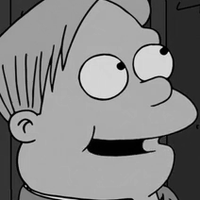

In [5]:
img = training_image_dictionary[24]

Next, we take the images in array format and vectorize them. 
* _What do we mean by vectorize_? Each $N\times{N}$ image array containing the grayscale values at each pixel is converted to an $N^{2}$ vector of values. What image class, i.e., what number it represents, is then converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). The converted data is stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.
* _What's the deal with Float32_? Most neural network libraries (or other machine learning calculations) use `Float32` (or lower) to save memory because of the large number of parameters associated with the network. Additionally, model training is often carried out using specialized hardware [such as Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/), which has different memory constraints.

In [6]:
training_image_dataset = let
    training_image_dataset = Dict{Int, Vector{Float32}}();
    number_of_training_examples = length(training_image_dictionary);
    for t ∈ 1:number_of_training_examples
        X = training_image_dictionary[t];
        D = Array{Float32,1}(undef, number_of_pixels);
        linearindex = 1;
        for row ∈ 1:number_of_rows
            for col ∈ 1:number_of_cols
                D[linearindex] = X[row,col];
                linearindex+=1;
            end
        end
        training_image_dataset[t] = D;
    end
    training_image_dataset
end;

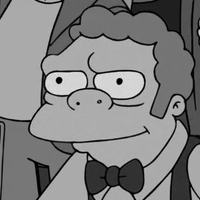

In [7]:
training_image_dataset[3] |> s-> decode(s, number_of_rows=200,number_of_cols=200) |> img -> Gray.(img)

Next, let's generate a random set of image indexes that we encode into the model. We'll store this collection in the `image_index_set_to_encode::Set{Int64}` variable.
* _How do we build this set_? We specify the number of images that we want in the `number_of_images_to_memorize::Int` variable; then we iterate using [a `while-loop`](https://docs.julialang.org/en/v1/base/base/#while) until we generate the required number of indexes _randomly_. We stop the loop once we hit our target number. Fun data structure question: why do we use [a Julia `Set`](https://docs.julialang.org/en/v1/base/collections/#Base.Set) instead of an array?

`Unhide` the code block below to see how we generated the `image_index_set_to_encode::Set{Int}` index set.

In [8]:
image_index_set_to_encode = let

    # how many images do we want to encode?
    number_of_possible_images = length(training_image_dataset);
    image_index_set_to_encode = Set{Int64}();

    is_ok_to_stop = false; # iteration flag
    while (is_ok_to_stop == false)
        
        # generate a random index -
        j = rand(1:number_of_possible_images);
        push!(image_index_set_to_encode, j); # add to the image set -

        # check: have we hit the number that we want?
        if (length(image_index_set_to_encode) ≥ number_of_images_to_memorize)
            is_ok_to_stop = true;
        end
    end

    # return 
    image_index_set_to_encode;
end;

In [9]:
image_index_set_to_encode

Set{Int64} with 24 elements:
  122
  72
  569
  607
  11
  959
  237
  73
  319
  281
  593
  433
  51
  628
  774
  108
  212
  480
  363
  ⋮ 

## Task 2: Can we recover the corrupted memory?
In this task, we'll formulate a the image dataset that we give the network, and then we'll create a model of a modern Hopfield network. Finally, we'll some quick checks to make sure we are doing what we think we are doing.

Let's start by creating a model of a modern Hopfield network. 
* We'll construct [a `MyModernHopfieldNetworkModel` instance](src/Types.jl) using a custom [`build(...)` function](src/Factory.jl). The [`build(...)` method](src/Factory.jl) takes the type of thing we want to build, the (linearized) image library we want to encode, and the (inverse) system temperature $\beta$ as inputs. Images along the columns.
* The [`build(...)` function](src/Factory.jl) returns a `MyModernHopfieldNetworkModel` instance, where the image library is stored in the `X::Array{Float32,2}` field, and the system temperature is stored in the `β::Float64` field.

We'll store the problem instance in the `model::MyModernHopfieldNetworkModel` variable.

In [10]:
model = let

    number_of_images_to_learn = length(image_index_set_to_encode);
    linearimagecollection = Array{Float32,2}(undef, number_of_pixels, number_of_images_to_learn); # images on columns
    
    # turn our set into a sorted vector -
    index_vector = image_index_set_to_encode |> collect |> sort; # we'll process this in this order 

    # populate the data array -
    for k ∈ eachindex(index_vector)
        j = index_vector[k];
        sₖ = training_image_dataset[j];
        for i ∈ 1:number_of_pixels
            linearimagecollection[i,k] = sₖ[i];  # fill the columns of the array -
        end
    end
    
    # build model -
    model = build(MyModernHopfieldNetworkModel, (
            memories = linearimagecollection, # this is the data we want to memorize. Images on columns
            β = β, # Inverse temperature of the system. Big beta means we are more likely to get the right answer
    ));
     
    model;
end;

__Check__: Let's do a quick check to make sure we are doing what we think we are doing. Let's check what's stored in the columns of the `model.X` field. These should be the images that we are trying to encode.

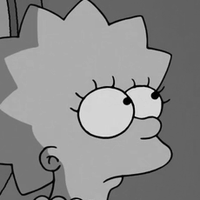

In [11]:
let
    X = model.X; # get the training data in the model
    index_to_check = 4; # what index do we want to check?
    X[:,4] |> s-> decode(s, number_of_rows = number_of_rows, 
        number_of_cols = number_of_cols) |> img -> Gray.(img)
end

## Task 3: Retrieve a memory from the network
In this task, we will retrieve a memory from the Hopfield network starting from a random state vector $\mathbf{s}_{\circ}$. 
* _What should we expect_: We are guaranteed that the network will converge to a local minimum, but we are not guaranteed that the local minimum is the same as the original image. Convergence should occur in less that or equal to the number of pixels in the image.

Let's start by specifying which of the images we expect to recover in the `imageindextorecover::Int` variable.

In [12]:
imageindextorecover = 4; # which element of the index vector will we choose?

Next, build a corrupted initial condition vector based on this image, which we'll store in the `sₒ::Array{Float32,1}` variable. We'll iterate through each pixel from the original image, sometimes we'll make a mistake and replace the correct pixel value with a incorrect value.
* _What is the $\theta$ parameter_? The $\theta$ hyperparameter controls how often we make mistakes. It's interpretation depends upon our _mistake_ model. For example, if we are cutting off some fraction of the image, then $\theta$ describes the fraction of the image that we are cutting off. Alternatively, if we are adding noise, then $1 - \theta$ describes the fraction of the original image that we are keeping.

Which ever model we use, the $\theta\in[0,1]$. We store the curropted image in the `sₒ::Array{Float32,1}` variable.

In [26]:
sₒ = let

    index_vector = image_index_set_to_encode |> collect |> sort; # we'll process this in this order
    index_of_image_to_encode = index_vector[imageindextorecover]; # -or- choose random
        
    # initialize -
    ŝₖ = training_image_dataset[index_of_image_to_encode]; # raw state *not* scaled to -1,1
    sₒ = Array{Float32,1}(undef, number_of_pixels); # initialize some space
    θ = 0.80; # threshold (fraction correct in cutoff image case)

    for i ∈ 1:number_of_pixels
        pixel =  ŝₖ[i]; # We have some gray-scale values in the original vector, need to perturb
        if (rand() ≤ θ)
            sₒ[i] = rand(); # add some random noise
        else
            sₒ[i] = pixel;
        end
    end
    
    # cutoff = (1-θ)*number_of_pixels |> x-> round(Int,x);
    # for i ∈ 1:number_of_pixels
    #     pixel =  ŝₖ[i]; # We have some gray-scale values in the original vector, need to perturb
    #     if (i ≤ cutoff)
    #         sₒ[i] = pixel;
    #     else
    #         sₒ[i] = 0.0;
    #     end
    # end
    
    sₒ
end;

What does the initial state vector $\mathbf{s}_{\circ}$ look like (this should be a corrupted version of the `imageindextorecover` image):

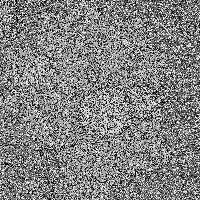

In [27]:
decode(sₒ, number_of_rows = number_of_rows, 
    number_of_cols = number_of_cols) |> img -> Gray.(img) # corrupted true image. This is what *we give the network*

Now that we have a starting memory encoded in the state vector $\mathbf{s}_{\circ}$, can we recover the original image?
* _Implementation_: We implemented the modern Hopfield recovery alogorithm above in [the `recover(...)` method](src/Compute.jl). This method takes our `model::MyModernHopfieldNetworkModel` instance, the initial configuration vector `sₒ::Array{Int32,1}`, and the maximum number `maxiterations::Int64`, and iteration tolerance parameter `ϵ::Float64` . 
* [The `recover(...)` method](src/Compute.jl) returns returns the recovered image in the e`s₁::Array{Float32,1}` variabl, the image at each iteration in the `f::Dict{Int,Array{Float32,2}}` dictionary, and the probability of the image at each iteration in the `p::Dict{Int,Array{Float32,2}}` variable.

How many iterations did it take to converge? 

In [ ]:
(s₁,f,p) = recover(model, sₒ, maxiterations = 10000, ϵ = 1e-16); # iterate until we hit stop condition

In [ ]:
println("How many iterations: $(length(f))") # how many iterations did we need to converge?

How many iterations: 3



__Check__: Let's check to see if the recovered image is the same as the original image. We can do this by checking the `s₁::Array{Float32,1}` variable against the original image.

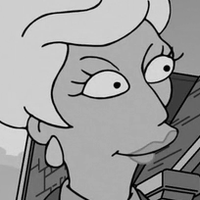

In [17]:
decode(s₁, number_of_rows = number_of_rows, 
        number_of_cols = number_of_cols) |> img -> Gray.(img) # After n iterations, this is what the network gave us back

Sometimes this works, and sometimes it doesn't. Let's step through the frames and see what we see.

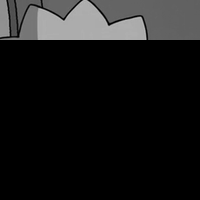

In [18]:
let
    n = 0;
    decode(f[n], number_of_rows = number_of_rows, 
        number_of_cols = number_of_cols) |> img -> Gray.(img) # After n iterations, this is what the network gave us back
end

### Hmmm. Sometimes, this works. What is going on?
Let's implement the iteration logic in [the `recover(...)` method](src/Compute.jl) and try to understand what is going on. In each iteration $t$ of the loop, we compute a probability vector $\mathbf{p}_{t}$ and a new state vector $\mathbf{s}_{t}$. 

#### Key points
The probability vector $\mathbf{p}_{t} = \texttt{softmax}(\beta\cdot\mathbf{X}^{\top}\mathbf{s}_{t})$ is computed using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). The softmax function takes a vector of real numbers and converts it into a probability distribution. The softmax function is defined as:
$$
\begin{align*}
p_{i} = \texttt{softmax}(x)_{i} = \frac{e^{x_{i}}}{\sum_{j=1}^{N}e^{x_{j}}}\quad\forall i\in\{1,\ldots,N\}
\end{align*}
$$
where $\mathbf{x}$ is the input vector, and $p_{i}$ is the $i$-th element of the output vector, and $N$ is the number of elements in the input vector (number of pxiels in the image). The next state vector $\mathbf{s}_{t+1} = \mathbf{X}\cdot\mathbf{p}_{t}$ is computed using the matrix multiplication of the image library $\mathbf{X}$ and the probability vector $\mathbf{p}_{t}$. 
* _Super interesting_: As the networks choice becomes more sure, the probability vector $\mathbf{p}_{t}\rightarrow{e}_{\star}$ converges to a single image, where $e_{\star}$ is a one-hot vector of describing the chosen image (e.g., a standard basis vector).
* _Even more interesting_: The probability vector $\mathbf{p}_{t}$ is a probability distribution over the images in the library. Thus, it also describes the _mixing_ of the images in the library. It represents the weights in a weighted sum of possible images.

Let's check out what is going on, especiallay as we increase/decrease the temperature $\beta$ parameter.

In [20]:
tmp, ptmp = let

    X = model.X;
    β = model.β;

    tmp = β*transpose(X)*sₒ;
    p = softmax(tmp)
    
    tmp,p
end

([25218.0419921875, 12658.284912109375, 20940.64453125, 20522.48779296875, 18025.72265625, 28192.72705078125, 23689.2822265625, 22312.91259765625, 21153.9208984375, 19993.336181640625  …  8728.993530273438, 16480.947265625, 20856.8359375, 21592.4072265625, 17625.00244140625, 18491.27197265625, 21847.900390625, 21388.70849609375, 16461.695556640625, 16669.073486328125], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [21]:
tmp

24-element Vector{Float64}:
 25218.0419921875
 12658.284912109375
 20940.64453125
 20522.48779296875
 18025.72265625
 28192.72705078125
 23689.2822265625
 22312.91259765625
 21153.9208984375
 19993.336181640625
     ⋮
 16480.947265625
 20856.8359375
 21592.4072265625
 17625.00244140625
 18491.27197265625
 21847.900390625
 21388.70849609375
 16461.695556640625
 16669.073486328125

In [22]:
θ = let
    θ = zeros(number_of_images_to_memorize);
    for i ∈ 1:number_of_images_to_memorize
        θ[i] = exp(tmp[i]);
    end
    Z = sum(θ);
    θ = θ*(1/Z);
end

24-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

## Next time.
In lecture `L10a` we'll explore another proto neural network, [the Boltzmann machine](https://en.wikipedia.org/wiki/Boltzmann_machine). A [Boltzmann machine](https://en.wikipedia.org/wiki/Boltzmann_machine) is a stochastic neural network model consisting of symmetrically connected binary units that make probabilistic decisions about their states.
* The creator of the Boltzmann machine, Geoffrey Hinton, is one of the pioneers of deep learning, and shared the [the Nobel Prize in Physics in 2025](https://news.cornell.edu/stories/2024/10/john-hopfield-phd-58-wins-nobel-prize-physics) with John Hopfield.

# Today?
That's a wrap! What are some of the interesting things we discussed today?